# TIME-TO-SPACE CONVERSION FOR STICKNET OBSERVATIONS

This notebook replaces the old MATLAB tsdriver.m and time_space_conversion3batch.m scripts used to convert time observations to spatial coordinates, specifically related to StickNet observations ahead of supercell thunderstorms. This script has been written specifically on the Mac platform and would need to be adjusted slightly for Windows use



Dependent python libraries are pandas, datetime, matplotlib, and metpy. The rest should be fairly standard implementation in any python build

In [1]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import glob 
import datetime as dt

from metpy.calc import get_wind_components
from metpy.units import units

from scipy import interpolate
import scipy.ndimage as nd


from pylab import cm
from mpl_toolkits.basemap import Basemap


from netCDF4 import num2date
import numpy as np
import pyart
import glob
import pytz
import SNmods as snmods
import probe_info
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind
from functions_radar import get_radar_from_aws,_nearestDate
from scipy import interpolate
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### CODE BELOW HAS BEEN ALTERED TO EXECUTE IN PYTHON
### Altered: March 2017, AARON HILL

###  Originally written by Brian Hirth, adapted by Pat Skinner and Brad Charboneau.

###   This code accepts stationary StickNet data and performs time to space conversion analysis on it.  This comment section describes how it works and how to use it step by step. Hopefully this helps... Happy coding!

###   1.  Specify your input and output directories.  This will undoubdedtly need to be edited to match your preferences.

###   2.  Select the start time  and duration of the time-space window. The duration should be IN MINUTES.

###   3.  Select your variables for analysis.  Make sure to pick a variable in the list outlined below, and make sure it is typed exactly as shown.

###   4.  Select a storm motion in meters per second.  You'll need the x and y components.

###   5.  Select a reference latitude, longitude and elevation.  This will represent the origin of the domain.

###   7.  Select a base state value for theta-e and theta-v.  For absolute values this should be set to 0.

###   8.  Select the probe IDs you wish to include in the analysis and output.

###   9.  Select whether you wish to use ground relative or storm relative winds.




# SET SOME VARIABLES AND CONSTANTS

### The values below were calculated by J. McDonald 2017
### They are not "truth" and can be modified 

In [11]:

# 
# Specify the date of the event, along with the directory where data is stored 
#target_date = '20170430'
#target_date = '20160331'
target_date = '20160430'
#target_date = '20170325'

if target_date == '20160331':
    # Designate the start hour, minute, and second of analysis and the duration 
    start_hour = 21
    start_min = 40
    start_sec = 0
    duration = 75 # in minutes
    perturbation = True
    # base state variables
    temp = 72.3 #F
    dewp = 64.0 #F
    pres = 983 # STATION PRESSURE
    #storm motion (using radar/latlon method)
    conversion_x = 17.7  
    conversion_y = 6.6 
    # Reference elevation, latitude, and longitude to center the analysis on (storm motion script)
    ref_lat = 35.1
    ref_lon = -87.7
    ref_elevation = 247.0
    probes = [218,217,221,222,219,220]    # 4/1/16 Collinwood, TN (VortexSE)

if target_date == '20170430':
    #midpoint is 1837... 30 mins on either side
    start_hour = 18
    start_min = 7
    start_sec = 0
    duration = 60 
    perturbation = True
    temp = 80.5 #F
    dewp = 64 #F
    pres = 989 #mb STATION PRESSURE
    # storm motion
    conversion_x = 12.8
    conversion_y = 21.0   
    # storm motion script, average of probes 
    ref_lat = 34.5
    ref_lon = -87.2
    ref_elevation = 174.3
    #probes = [218,219,222,221,224]  # 20170430
    probes = [218,219,222,221,224,220]
    
if target_date == '20160430':
    start_hour = 20
    start_min = 59
    start_sec = 0
    duration = 60
    #storm motion
    conversion_x = 9.4
    conversion_y = 11.6
    perturbation = False
    #ref values
#     ref_elevation = 200
#     ref_lat = 34.54
#     ref_lon = -87.35
    ref_lat = 34.5
    ref_lon = -87.3
    ref_elevation = 179.2
    perturbation = True
    temp = 74 #F
    dewp = 67 #F
    pres = 988 #mb STATION PRESSURE

    probes = [224,218,223,221,217,222,219,220]    # 4/30 2016 VSE


# Required: Bias text file containing probe bias for T,P,RH,WS,WD in the same target directory as the data
bias_filename = target_date+'_Bias.txt'
directory = '/home/jessmcd/VortexSE/'+target_date+'/Time2Space/'
output_directory = directory+'figs'
# Optional Variables:
# temperature, dewpoint, theta_e, theta_v, pressure, mslp, relative_humidity
vargroup           = ['temperature','dewpoint','pressure','theta_e','theta_v']  # variables for analysis

if perturbation:
    # calculate Theta E
    temp = (temp - 32) * 5/9
    dewp = (dewp - 32) * 5/9
    thetae = calc_thetae(temp,dewp,pres)
    # calculate Theta V
    thetav = calc_thetav(temp,dewp,pres)
    print(thetae, thetav)
else:
    pres = 0
    thetae = 0
    thetav = 0
    
# Base state variables for analysis, set values to 0.0 to be absolute
#MSLP_base_state = 990.0   %4/1/16 Collinwood, TN
#theta_e_base_state = 340.0
#theta_v_base_state = 303.0

MSLP_base_state = pres     
theta_e_base_state = thetae
theta_v_base_state = thetav

#Select 1 for storm relative, 0 for ground relative calculations
storm_relative = 0

339.866882625 300.1499318690086


# MORE CONSTANTS BUT THESE DONT NEED ALTERING

In [12]:
# Start and end time of analysis in seconds
start_time_seconds = start_hour * 3600 + start_min * 60 + start_sec
end_time_seconds = start_time_seconds + duration * 60

# Bias file should be in analysis directory
bias_path = '{0}/{1}'.format(directory,bias_filename)
bias = pd.read_csv(bias_path,index_col='ID',delim_whitespace=True)

# Convert lat/lon to meters for conversion in a cartesian grid
m1 = 111132.92  #lat calc term 1
m2 = -559.82    #lat calc term 2
m3 = 1.175      #lat calc term 3
m4 = -0.0023    #lat calc term 4
p1 = 111412.84  #lon calc term 1
p2 = -93.5      #lon calc term 2
p3 = 0.118      #lon calc term3
 
lat_convert = m1 + (m2*np.cos(np.deg2rad(2*ref_lat)))+(m3*np.cos(np.deg2rad(4*ref_lat)))+(m4*np.cos(np.deg2rad(6*ref_lat)))
lon_convert = (p1 * np.cos(np.deg2rad(ref_lat))) + (p2 * np.cos(np.deg2rad(3*ref_lat)))+(p3*np.cos(np.deg2rad(5*ref_lat)))


# Make a dictionary that controls variables for reading from the datafiles
indeces = {'temperature':'T',
          'relative_humidity':'RH',
          'pressure':'P',
          'wind_speed':'windsp',
          'wind_direction':'winddir'}

# Grab files in analysis directory
files = glob.glob('{0}/*_{1}*.txt'.format(directory,target_date))

# STICKNET OBJECT CLASS FOR PARSING DATA

In [13]:
# Python class used to read in StickNet data from a .txt file, output by the data acquisition software

class SNFile(object):
    def __init__(self, filename):
        self.year = int(filename[-19:-15])
        self.month = int(filename[-15:-13])
        self.day = int(filename[-13:-11])
        self.hour = int(filename[-10:-8])
        self.minute = int(filename[-8:-6])
        self.datetime = dt.datetime(self.year,self.month,self.day)
        self.filename = filename
        self.probe = filename[-25:-21]
        f = open(self.filename)
        header = f.readline().split()
        self.header = header[0]
        f.close()
        
    def parse(self, time):
        time = "%08.1f"%time
        if time == 000000.0:
            self.datetime += dt.timedelta(days=1) 
        hour,minute,second,msec = int(time[0:2]),int(time[2:4]),int(time[4:6]),int(time[-1])
        return self.datetime + dt.timedelta(hours=hour,minutes=minute,seconds=second,microseconds=msec*100000)
    
    # for 2017 data
    def parse_new(self, time):
        return dt.datetime.strptime(time,'%Y%m%d_%H%M%S.%f')
        
    def read(self):
        # for rapid probes, that don't have the extra data point at the end
        sn = pd.read_csv(self.filename, names=['time','T','RH','P','windsp','winddir','batt','flag','flag2'],
                         dtype={'time':np.float},parse_dates=[0],date_parser=self.parse,header=1,error_bad_lines=False)
        
        sn['ID'] = pd.Series(self.probe,index=sn.index)
        sn.index = sn['time']
        return sn
    
    # for 2017 data
    def read_new(self):
        # for rapid probes, that don't have the extra data point at the end
        sn = pd.read_csv(self.filename, names=['time','T','RH','P','windsp','winddir','batt','flag','flag2'],
                         dtype={'time':np.str},parse_dates=[0],date_parser=self.parse_new,header=1,error_bad_lines=False)
        
        sn['ID'] = pd.Series(self.probe,index=sn.index)
        sn.index = sn['time']
        return sn    

# MAIN CODE TO CONVERT TIME TO SPACE FOR EACH VARIABLE AND STICKNET FILE

In [14]:
for variable in vargroup:

#==========================================================================
#   Variable and File Initializations
#==========================================================================

    output_data = []
    wind_output = []
    min_position = []
    max_position = []
    
    wind_output_file     = '{0}/{1}_raw_wind_{2}{3}_{4}.csv'.format(output_directory,target_date,start_hour,start_min,duration)
    min_position_file    = '{0}/{1}_min_position_{2}{3}_{4}.csv'.format(output_directory,target_date,start_hour,start_min,duration)
    max_position_file    = '{0}/{1}_max_position_{2}{3}_{4}.csv'.format(output_directory,target_date,start_hour,start_min,duration)
    t_output             = '{0}/{1}_tornado_position_{2}{3}_{4}.csv'.format(output_directory,target_date,start_hour,start_min,duration)
    wind_output_file_2   = '{0}/{1}_dec_wind_{2}{3}_{4}.csv'.format(output_directory,target_date,start_hour,start_min,duration)
    output_file          = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
    
    first_file = 1    
    
    for snfile in files:
        # Read file and parse header
        data_ob = SNFile(snfile)
        data = data_ob.read()   # EDIT IF CHANGING FROM 2016 TO 2017
       # data = data_ob.read_new()
        header = data_ob.header
        splits = data_ob.header.split(',')
        lat =  np.float(splits[3])
        lon = -1*np.float(splits[4])
        elevation = np.float(splits[5])
        id_probe = data_ob.probe
        bias_data = bias.loc[int(id_probe)]
        
        
        last_floor_input = 0
        first_ob = 1
        
        # Grab every tenth data point, decimates to 1 Hz data per the matlab code
        data_resample = data.iloc[::10,:]
        
        times = pd.DatetimeIndex(data_resample.index)

        # Verify the desire to analyze probe read in
        active = np.any(np.array(probes) == int(id_probe)) 

        # Loop over all the times
        for ob_time in times:
            ob_time_seconds = ob_time.hour*3600. + ob_time.minute*60. + ob_time.second

            # if the observation time is within start and end time, do analysis
            if ob_time_seconds >= start_time_seconds and ob_time_seconds <= end_time_seconds and active:
                tstr = str(ob_time_seconds)
                if (float(tstr[0:2])<6) and (start_time_seconds < 86400) and (start_time_seconds > 79200):
                    tstr = tstr+86400;
                
                # Set t and w flag to be 0 (FUTURE: READ IN T_FLAG AND W_FLAG FROM QC'ED DATA FILE)
                t_flag = 0
                w_flag = 0 
                
                
                if w_flag is 0:  # passes QC      
                    wind_dir = data_resample[indeces['wind_direction']][ob_time] - bias_data['WDIR']
                    wind_spd = data_resample[indeces['wind_speed']][ob_time] - bias_data['WSPD']
                    u_comp,v_comp = get_wind_components(wind_spd*units('m/s'),wind_dir*units.degree)
                else:            # fails QC
                    wind_dir = nan
                    u_comp,v_comp = np.nan,np.nan
                    
                    
                # Calculate the time in seconds relative to the centerpoint
                # of time window. -300 to 300 seconds for 10 minute window                    
                conversion_time = ob_time_seconds - start_time_seconds - duration*60./2
                
                
                # use the storm motion components and coordinate system conversion
                # factors to calculate the position (in km) from the reference coordinate
                # (origin) defined prior                
                y_pos = ((lat - ref_lat)*lat_convert - conversion_time * conversion_y)/1000.;
                x_pos = ((lon - ref_lon)*lon_convert - conversion_time * conversion_x)/1000.;
                
                
                #jessmcd edit: converted distance to lat lon so that radar data can be overlaid
                y_pos = ref_lat+((y_pos/(lat_convert)) * 1000.); # convert km to m, then from m to lat 
                x_pos = ref_lon+((x_pos/(lon_convert)) * 1000.);
                
                
                # Variables that need some calculations
                if variable == 'dewpoint' or variable == 'theta_e' or variable == 'theta_v' or variable == 'mslp':               
                    Rd = 287.1
                    g = 9.8
                    T_ref = 295.
                    
                    P = data_resample[indeces['pressure']][ob_time] - bias_data['P']
                    RH = data_resample[indeces['relative_humidity']][ob_time] - bias_data['RH']
                    T_K = data_resample[indeces['temperature']][ob_time] - bias_data['T'] + 273.15
                    theta = T_K*((1000./P)**(287./1004.))
                    s_vap_p = 6.11*np.exp((2500000./461.)*(1/273.15 - 1/T_K))
                    vap_p = RH*s_vap_p/100.
                    MR = 0.622*vap_p/(P-vap_p)
                    H = Rd*T_ref/g
                    
                    if variable == 'theta_e':
                        if t_flag == 0:
                            T_star = 2840./(3.5*np.log(T_K) - np.log(vap_p) - 4.805) + 55
                            theta_e = T_K*((1000.0/P)**(0.2854*(1-0.28*MR)))*np.exp(MR*(1+0.81*MR)*(3376./T_star-2.54))
                            ob_final = theta_e - theta_e_base_state
                        else: ob_final = -999.9
                    if variable == 'theta_v':
                        if t_flag == 0:
                            ql = 0
                            theta_v = theta*(1+0.61*MR-ql)
                            ob_final = theta_v-theta_v_base_state
                        else: ob_final = -999.9
            
                    if variable == 'dewpoint':
                        if t_flag == 0:
                            dewpoint = (237.3*np.log(vap_p/6.1078)) / (17.27 - np.log(vap_p/6.1078))
                            ob_final = dewpoint
                        else: ob_final = -999.9
                    
                    if variable == 'mslp':
                        if t_flag == 0:
                            mslp = P*np.exp(elevation/H)
                            ob_final = mslp-mslp_base_state
                        else: ob_final = -999.9
                else:
                    if t_flag == 0:
                        ob_final = data_resample[indeces[variable]][ob_time]
                    else: ob_final = -999.9

                        
                if elevation == 0.0:
                    elevation = ref_elevation
                
                
                if first_ob == 1:
                    max_position.append([x_pos,y_pos])
                    if first_file > 1:
                        min_position.append([min_x,min_y])
                    first_file += 1
                else:
                    min_x = x_pos
                    min_y = y_pos

                # if observation is not bad, write to file
                if ob_final != -999.9:
                    output_data.append([x_pos,y_pos,ob_final])
                    
                
                # calculate winds storm relative or ground relative
                if storm_relative == 0:
                    u_comp,v_comp = u_comp.magnitude,v_comp.magnitude
                else:
                    u_comp = u_comp.magnitude + conversion_x
                    v_comp = v_comp.magnitude + conversion_y
                  
                wind_output.append([id_probe,ob_time_seconds,u_comp,v_comp,x_pos,y_pos]) 

                first_ob += 1

    # Write data to .csv files for later plotting
    min_position.append([min_x,min_y]) 
    
    df = pd.DataFrame(output_data, columns=["x_pos","y_pos","val"])
    df.to_csv(output_file, index=False)
    
    df = pd.DataFrame(max_position,columns=["x_pos","y_pos"])
    df.to_csv(max_position_file,index=False)
    
    df = pd.DataFrame(min_position,columns=['x_pos','y_pos'])
    df.to_csv(min_position_file,index=False)
    
    df = pd.DataFrame(wind_output,columns=['id','time','u_comp','v_comp','x_pos','y_pos'])
    df.to_csv(wind_output_file,index=False)
    #write csv files for output data, wind output, min position, and max position

/home/jessmcd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in log
/home/jessmcd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log


# PLOTTING TIME TO SPACE CONVERSION FROM FILE OUTPUT

## Use plot_time_to_space_latlon.ipynb for actual plotting. The script below is for testing only

In [8]:
def convert_lon_lat(ref_lon,ref_lat,x,y):
    ''' This function takes a reference lon and lat (the location of the radar) and converts the x and y 
    coordinates in km from the radar (radar._get_x_y(...) into lons and lats for plotting on basemap)'''
    # Convert lat/lon to meters for conversion in a cartesian grid
    m1 = 111132.92  #lat calc term 1
    m2 = -559.82    #lat calc term 2
    m3 = 1.175      #lat calc term 3
    m4 = -0.0023    #lat calc term 4
    p1 = 111412.84  #lon calc term 1
    p2 = -93.5      #lon calc term 2
    p3 = 0.118      #lon calc term3
    
    x *= 1000
    y *=1000
    
    lat_convert = m1 + (m2*np.cos(np.deg2rad(2*ref_lat)))+(m3*np.cos(np.deg2rad(4*ref_lat)))+(m4*np.cos(np.deg2rad(6*ref_lat)))
    lon_convert = (p1 * np.cos(np.deg2rad(ref_lat))) + (p2 * np.cos(np.deg2rad(3*ref_lat)))+(p3*np.cos(np.deg2rad(5*ref_lat)))

    lon_pos = [(ref_lon+(x_pos/lon_convert)) for x_pos in x]
    lat_pos = [(ref_lat+(y_pos/lat_convert)) for y_pos in y]
    
    lon_pos = np.array(lon_pos)
    lat_pos = np.array(lat_pos)

    return lon_pos,lat_pos

def plot_variable_radar(X,Y,ref_lat, ref_lon, variable, contour_range, radar, file_path, file_path_wind, save_path):

    # create interpolated grid from time2space data 
    data = pd.read_csv(file_path,names=['x_pos','y_pos','val'],header=1)
    zi = interpolate.griddata((data['x_pos'],data['y_pos']),data['val'],(X,Y))

    if contour_range is None:
        clevels = np.arange(np.min(zi),np.max(zi),20)
    else: clevels = contour_range

    # make radar title
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                          radar.time['units'])
    central = pytz.timezone('US/Central')
    local_time = central.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%Y-%m-%d %H:%M UTC')
    name = '40 dBZ Contour'
    title   = '\n{0} {1} {2} ({3})'.format(station,name,fancy_date_string,fancy_date_string_utc)

    # get radar data
    display = pyart.graph.RadarMapDisplay(radar)
    radar_lat = display.loc[0]
    radar_lon = display.loc[1]
    lat_1 = 35.5


    # Initialize plot and basemap
    fig = plt.figure(figsize = [15,10])
    ax = fig.add_subplot(111)

#     llcrnrlon= ref_lon - 0.35
#     llcrnrlat= ref_lat - 0.21
#     urcrnrlon= ref_lon + 0.25
#     urcrnrlat= ref_lat + 0.159

    llcrnrlon= X[0][0]
    llcrnrlat= Y[0][-1]
    urcrnrlon= X[0][-1]
    urcrnrlat= Y[-1][-1]
    m = Basemap(resolution = 'i',projection='merc',lat_ts = 35.5,
                    llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,
                    urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat)
    m.drawcounties()

    #plot time-to-space data grid
    xx, yy = m(X,Y)
    C = m.contourf(xx,yy, nd.filters.gaussian_filter(zi,2.0),levels=clevels,cmap=cm.RdBu_r, alpha = 0.7)
    m.contour(xx,yy, nd.filters.gaussian_filter(zi,2.0),levels=C.levels,colors='k', linewidths = 0.5)
    clb = fig.colorbar(C)
    clb.ax.set_title('K')
    
    # title
    ax.set_title(obtitle+title, fontsize = 14, y = 1.01)
    
    #plot radar contour
        
    # get reflectivity
    field, sweep = ('reflectivity',0)
    x,y = display._get_x_y(sweep = sweep, edges = False, filter_transitions = True)
    data = radar.get_field(sweep,field)
    data = nd.gaussian_filter(data, sigma = 1.2)
    #convert coordinates from km to lat/lon
    lon_pos,lat_pos = convert_lon_lat(radar_lon,radar_lat,x,y)
    
    m.contour(lon_pos,lat_pos,data, levels = [40], latlon = True, colors = '#8F8F8F', linewidths = 4)
    
    # plot velocity
#     field, sweep = ('velocity',1)
#     x,y = display._get_x_y(sweep = sweep, edges = False, filter_transitions = True)
#     data = radar.get_field(sweep,field)
#     data = nd.gaussian_filter(data, sigma = 1.2)
    
#     m.contour(lon_pos,lat_pos,data, levels = [-60], latlon = True, colors = 'b', linewidths = 1)

    #wind data
    data_wind = pd.read_csv(file_path_wind,names=['id','time','u_comp','v_comp','x_pos','y_pos'],header=1)
    wind = np.sqrt((np.array(data_wind['u_comp'].values)**2) + (np.array(data_wind['v_comp'].values)**2))

    m.barbs(data_wind['x_pos'].values[::100],data_wind['y_pos'].values[::100],
            data_wind['u_comp'].values[::100]*1.94384,data_wind['v_comp'].values[::100]*1.94384, latlon = True)

    #save figure
    plt.savefig(save_path,dpi=300)
    show() #remove and add savefig command once in function 

### MAKE ANALYSIS GRID

In [21]:
# 160331
yi = np.arange(34.89,35.25,0.001)
xi = np.arange(-88.05,-87.45,0.001)
X,Y = np.meshgrid(xi,yi)

### PLOT A VARIABLE FROM FILE OUTPUT

### 20160331

308 308


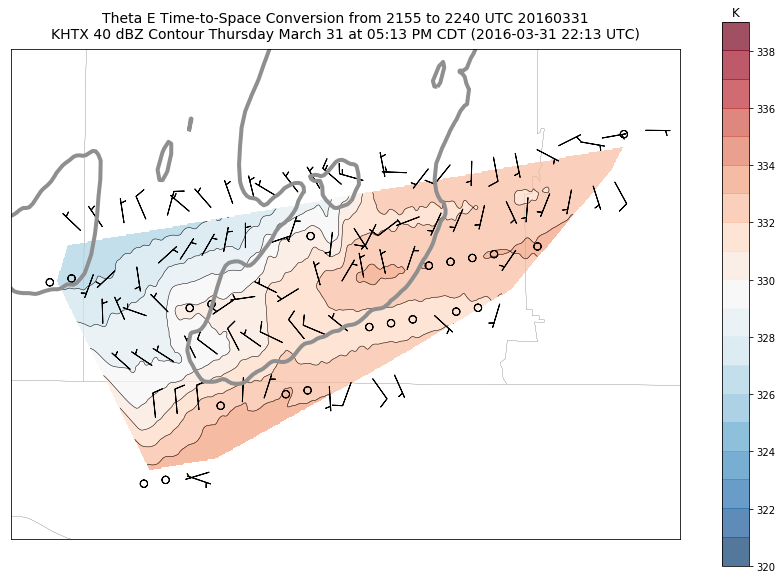

In [22]:
# 20160331 only
target_date = '20160331'
directory = '/home/jessmcd/VortexSE/'+target_date+'/Time2Space/'
output_directory = directory+'figs'

# User edit
variable = 'theta_e'
obtitle = 'Theta E Time-to-Space Conversion from 2155 to 2240 UTC 20160331'

file_path = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
file_path_wind = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,'raw_wind',start_hour,start_min,duration)
save_path='{0}/{1}_{2}_{3}.png'.format(output_directory,target_date,variable,'winds')
contour_range = np.arange(320,340,1.0)

# get radar data
station = 'KHTX'
analysis_time = dt.datetime(2016,3,31,22,13)
field = 'reflectivity'
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]

# plot
plot_variable_radar(X,Y,ref_lat, ref_lon,\
                    variable, contour_range, \
                    radar,\
                    file_path, file_path_wind, save_path)

308 308


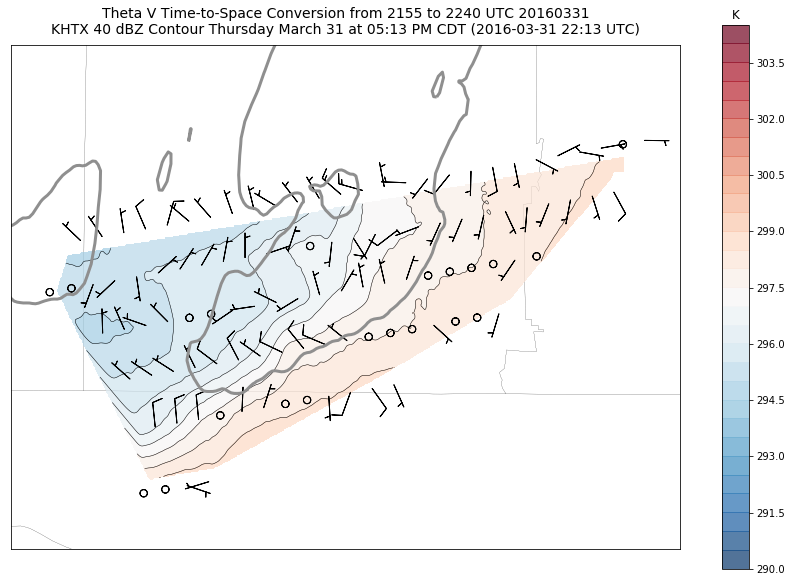

In [12]:
variable = 'theta_v'
obtitle = 'Theta V Time-to-Space Conversion from 2155 to 2240 UTC 20160331'

file_path = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
file_path_wind = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,'raw_wind',start_hour,start_min,duration)
save_path='{0}/{1}_{2}_{3}.png'.format(output_directory,target_date,variable,'winds')
field = 'reflectivity'

# get radar data.... have this occur outside of function later
station = 'KHTX'
analysis_time = dt.datetime(2016,3,31,22,13)
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]
contour_range = np.arange(290,305,0.5)

plot_variable_radar(X,Y,ref_lat, ref_lon,\
                    variable, contour_range, \
                    radar,\
                    file_path, file_path_wind, save_path)

### 20160430

In [18]:
# 160430
yi = np.arange(34.25,34.75,0.001)
xi = np.arange(-87.55,-87.13,0.001)
X,Y = np.meshgrid(xi,yi)

294 294


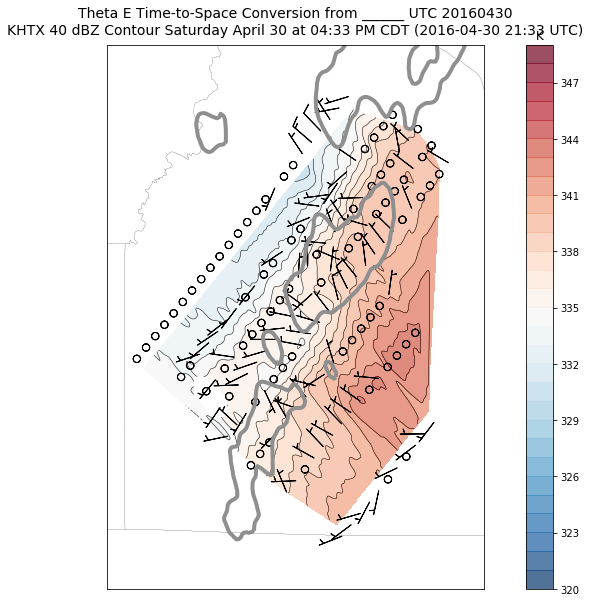

In [19]:
# 20160430 only
target_date = '20160430'
output_directory = directory+'/figs'

# User edit
variable = 'theta_e'
obtitle = 'Theta E Time-to-Space Conversion from ______ UTC 20160430'

file_path = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
file_path_wind = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,'raw_wind',start_hour,start_min,duration)
save_path='{0}/{1}_{2}_{3}.png'.format(output_directory,target_date,variable,'winds')
contour_range = np.arange(320,350,1.0)

# get radar data
station = 'KHTX'
analysis_time = dt.datetime(2016,4,30,21,33)
field = 'reflectivity'
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]

# plot
plot_variable_radar(X,Y,ref_lat, ref_lon,\
                    variable, contour_range, \
                    radar,\
                    file_path, file_path_wind, save_path)